# Classification Modelle

# Setup
---

### Import Module & Libraries

Zu Beginn werden die benötigten Komponenten aus den entsprechenden Libraries importiert.

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import chi2_contingency, fisher_exact

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import sklearn.linear_model as skl_lm


# Module für Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

sns.set_theme()
%matplotlib inline

### Erstellen einer Pipeline

Um die numerische und kategoriale Variablen automatisch in ein korrektes Format für die scikit learn Modelle zu transformieren, wird an dieser Stelle eine Pipeline definiert. Diese besteht aus verschiedenen Elementen, welche bspw. fehlende Werte ausfüllt (SimpleImputer) oder kategoriale Variablen in ein binäres Format umwandelt (OneHotEncoder).

In [3]:
# für numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

In [4]:
# für categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [5]:
# Erstellen der Pipeline, zusammenführen von cat und numeric transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

# Import Data
---

Als nächstes wird der Datensatz aus dem GitHub Repository importiert.

In [6]:
ROOT = "https://raw.githubusercontent.com/jan-kirenz/project-OliScha/main/"
DATA = "project_data.csv?token=GHSAT0AAAAAABPCEITIYHBIEPRTFMZJXUGKYPKREJQ"

df = pd.read_csv(ROOT + DATA)

Wir werfen einen ersten Blick auf die Daten um zu prüfen, ob der Import funktioniert hat. Hier fällt direkt auf, dass die erste Observation durch Text und ein Währungszeichen verunreigt ist.

In [7]:
# prüfen ob Import funktioniert hat
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


# Data Split
---

Direkt nach dem Import und einem ersten Blick auf die Daten werden die Daten in Traings- und Testdaten aufgeteilt. Alle folgenden Schritt finden auf Basis der Trainingsdaten statt, um möglichst realistische Ergebnisse bei der späteren Evaluation mit Testdaten zu erzielen.

Dadurch soll ein möglichst realistischer generalization error (or out-of-sample error) erzielt werden.

Bestimmte Schritte der Datenaufbereitung (datatypes, selbst erstellte Variablen etc.) müssen dann späte rallerdings auch für die Testdaten durchgeführt werden, um diese zur Evaluation nutzen zu können.

In [8]:
# Data Split
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
14740,-117.05,32.58,22.0,2101,399.0,1551,371,4.1518,136900.0,NEAR OCEAN,below
10101,-117.97,33.92,32.0,2620,398.0,1296,429,5.7796,241300.0,<1H OCEAN,above
20566,-121.84,38.65,29.0,3167,548.0,1554,534,4.3487,200700.0,INLAND,above
2670,-115.60,33.20,37.0,709,187.0,390,142,2.4511,72500.0,INLAND,above
15709,-122.43,37.79,25.0,1637,394.0,649,379,5.0049,460000.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489.0,3944,1493,5.1948,203500.0,<1H OCEAN,above
8767,-118.39,33.81,35.0,1008,165.0,391,167,3.7778,487500.0,NEAR OCEAN,above
16388,-121.30,38.05,52.0,122,26.0,62,25,1.1500,112500.0,INLAND,below
19949,-119.37,36.21,35.0,2228,476.0,1567,449,1.4455,54100.0,INLAND,above


# Data Inspection & EDA
---

Die ausführliche Untersuchung und Interpretation der Variablen wird im Kapitel "Regression" behandelt und ist auch für diese Kapitel gültig, da es sich um die selben Daten handelt.  
  
  
    
      

# Data Transformation
---

## Anpassung Datatypes & Bereinigung

Hier werden die gleichen Schritte durchgeführt wie im regression notebook.

In [9]:
# die identifizierten Observations mit NULL values sollen nun entfernt werden
train_dataset = train_dataset.dropna()

In [ ]:
# change datatype zu string um str.replace transformation durchzuführen
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("string")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("string")

# Bereinigung der fehlerhaften Werte
train_dataset.median_house_value = train_dataset.median_house_value.str.replace("$", "", regex =True)
train_dataset.housing_median_age = train_dataset.housing_median_age.str.replace("years", "", regex =True)

In [ ]:
# Anpassung der datatypes
train_dataset['median_house_value'] = train_dataset['median_house_value'].astype("float64")
train_dataset['housing_median_age'] = train_dataset['housing_median_age'].astype("float64")
train_dataset['total_bedrooms'] = train_dataset['total_bedrooms'].astype("int64")
train_dataset['ocean_proximity'] = train_dataset['ocean_proximity'].astype("category")

In [ ]:
#correct price_category values
train_dataset['updated_price_cat'] = np.where(train_dataset.median_house_value >= 150000, 'above', 'below')

In [ ]:
train_dataset['updated_price_cat'] = train_dataset['updated_price_cat'].astype("category")

In [14]:
train_dataset = train_dataset.drop(columns=['price_category','median_house_value'])

In [15]:
train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,updated_price_cat
14740,-117.05,32.58,22.0,2101,399,1551,371,4.1518,NEAR OCEAN,below
10101,-117.97,33.92,32.0,2620,398,1296,429,5.7796,<1H OCEAN,above
20566,-121.84,38.65,29.0,3167,548,1554,534,4.3487,INLAND,above
2670,-115.60,33.20,37.0,709,187,390,142,2.4511,INLAND,below
15709,-122.43,37.79,25.0,1637,394,649,379,5.0049,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489,3944,1493,5.1948,<1H OCEAN,above
8767,-118.39,33.81,35.0,1008,165,391,167,3.7778,NEAR OCEAN,above
16388,-121.30,38.05,52.0,122,26,62,25,1.1500,INLAND,below
19949,-119.37,36.21,35.0,2228,476,1567,449,1.4455,INLAND,below


## Feature Engineering

In [16]:
# Erstellen neuer Variablen
train_dataset=train_dataset.assign(people_per_household=lambda train_dataset: train_dataset.population/train_dataset.households)
train_dataset=train_dataset.assign(bedrooms_per_household=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.households)
train_dataset=train_dataset.assign(rooms_per_household=lambda train_dataset: train_dataset.total_rooms/train_dataset.households)
train_dataset=train_dataset.assign(bedrooms_per_room=lambda train_dataset: train_dataset.total_bedrooms/train_dataset.total_rooms)

In [17]:
# people_per_household outlier droppen
train_dataset = train_dataset.drop(index=[19006,3364,16669,13034])
# rooms_per_household outlier droppen
train_dataset = train_dataset.drop(index=[1914,1979])
# bedrooms_per_household bereits in anderen enthalten und gedropped

In [18]:
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("ISLAND", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("NEAR BAY", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("NEAR OCEAN", "NEAR WATER", regex =True)
train_dataset.ocean_proximity = train_dataset.ocean_proximity.str.replace("<1H OCEAN", "NEAR WATER", regex =True)


In [19]:
# durch die gerade stattgefundene Transformation muss der datatype wieder korrigiert werden
train_dataset['ocean_proximity'] = train_dataset['ocean_proximity'].astype("category")

# Modelling

## Model 1 - Logistic Regression mit statsmodels

Zu Beginn wird eine Kopie des Trainingsdatensets erstellt, um dieses bearbeiten zu können und das Original Datenset noch für das nächste Model zur Verfügung zu haben ohne es erneut erzeugen zu müssen.

Zur Vorhersage für das Logistic Regression Modell werden die gleichen Features verwendet, welche sich bereits in der linearen Regression bewährt haben.

In [53]:
model1 = smf.glm(formula = 'updated_price_cat ~ median_income + ocean_proximity + bedrooms_per_room + people_per_household + housing_median_age', \
    data=train_dataset, family=sm.families.Binomial()).fit()

In [21]:
print(model1.summary())

                                    Generalized Linear Model Regression Results                                     
Dep. Variable:     ['updated_price_cat[above]', 'updated_price_cat[below]']   No. Observations:                16346
Model:                                                                  GLM   Df Residuals:                    16340
Model Family:                                                      Binomial   Df Model:                            5
Link Function:                                                        logit   Scale:                          1.0000
Method:                                                                IRLS   Log-Likelihood:                -5655.1
Date:                                                      Wed, 19 Jan 2022   Deviance:                       11310.
Time:                                                              19:36:37   Pearson chi2:                 1.45e+10
No. Iterations:                                                 

DIe P-Values der Features weisen alle einen Wert von unter 0,05 auf, was bedeutet, dass wir die Null Hypothese verwerfen können und die Features für unser Modell verwenden können.

### Predict

Im nächsten Schritt erstellen wir Vorhersagen auf Basis unseres Modells und erweitern unser dataset um die Angabe, bei welchem Threshold welche Vorhersage gemacht werden würde.

In [22]:
# Predictions erstellen und die Wahrscheinlichkeit zum dataset hinzufügen
train_dataset['Probability_above'] = model1.predict()

In [23]:
# Use thresholds to discretize Probability
train_dataset['Threshold 0.4'] = np.where(train_dataset['Probability_above'] > 0.4, 'above', 'below')
train_dataset['Threshold 0.5'] = np.where(train_dataset['Probability_above'] > 0.5, 'above', 'below')
train_dataset['Threshold 0.6'] = np.where(train_dataset['Probability_above'] > 0.6, 'above', 'below')
train_dataset['Threshold 0.7'] = np.where(train_dataset['Probability_above'] > 0.7, 'above', 'below')

train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,updated_price_cat,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room,Probability_above,Threshold 0.4,Threshold 0.5,Threshold 0.6,Threshold 0.7
14740,-117.05,32.58,22.0,2101,399,1551,371,4.1518,NEAR WATER,below,4.180593,1.075472,5.663073,0.189910,0.875462,above,above,above,above
10101,-117.97,33.92,32.0,2620,398,1296,429,5.7796,NEAR WATER,above,3.020979,0.927739,6.107226,0.151908,0.989435,above,above,above,above
20566,-121.84,38.65,29.0,3167,548,1554,534,4.3487,INLAND,above,2.910112,1.026217,5.930712,0.173034,0.492852,above,below,below,below
2670,-115.60,33.20,37.0,709,187,390,142,2.4511,INLAND,below,2.746479,1.316901,4.992958,0.263752,0.121762,below,below,below,below
15709,-122.43,37.79,25.0,1637,394,649,379,5.0049,NEAR WATER,above,1.712401,1.039578,4.319261,0.240684,0.989165,above,above,above,above
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489,3944,1493,5.1948,NEAR WATER,above,2.641661,0.997321,5.848627,0.170522,0.977437,above,above,above,above
8767,-118.39,33.81,35.0,1008,165,391,167,3.7778,NEAR WATER,above,2.341317,0.988024,6.035928,0.163690,0.851415,above,above,above,above
16388,-121.30,38.05,52.0,122,26,62,25,1.1500,INLAND,below,2.480000,1.040000,4.880000,0.213115,0.013403,below,below,below,below
19949,-119.37,36.21,35.0,2228,476,1567,449,1.4455,INLAND,below,3.489978,1.060134,4.962138,0.213645,0.013726,below,below,below,below


Im nächsten Schritt wird eine Funktion definiert, mit welcher die Confusion Matrizen für dieses Modell mit verschiedenen Thresholds dargestellt werden.

In [24]:
def print_metrics(train_dataset, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(train_dataset['updated_price_cat'], name='Actual')
    y_pred = pd.Series(train_dataset[predicted], name='Predicted')
    train_dataset_conf = pd.crosstab(y_actu, y_pred)
    display(train_dataset_conf)
    
    # Confusion Matrix to variables:
    pop = train_dataset_conf.values.sum()
    tp = train_dataset_conf['above']['above']
    tn = train_dataset_conf['below']['below']
    fp = train_dataset_conf['above']['below']
    fn = train_dataset_conf['below']['above']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')

In [25]:
print_metrics(train_dataset, 'Threshold 0.4')
print_metrics(train_dataset, 'Threshold 0.5')
print_metrics(train_dataset, 'Threshold 0.6')
print_metrics(train_dataset, 'Threshold 0.7')

--------------------------------------------------
Metrics for: Threshold 0.4



Predicted,above,below
Actual,,
above,9653,687
below,1873,4133


Accuracy:  0.8434
Precision: 0.8375
Recall:    0.9336
F1 Score:  0.8829 

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,above,below
Actual,,
above,9366,974
below,1441,4565


Accuracy:  0.8523
Precision: 0.8667
Recall:    0.9058
F1 Score:  0.8858 

--------------------------------------------------
Metrics for: Threshold 0.6



Predicted,above,below
Actual,,
above,8948,1392
below,1018,4988


Accuracy:  0.8526
Precision: 0.8979
Recall:    0.8654
F1 Score:  0.8813 

--------------------------------------------------
Metrics for: Threshold 0.7



Predicted,above,below
Actual,,
above,8302,2038
below,690,5316


Accuracy:  0.8331
Precision: 0.9233
Recall:    0.8029
F1 Score:  0.8589 



Aus der Sicht eines Immobilienunternehmens sollten weder zu viele Fehlinvestitionen getätigt werden noch gute Investitionsgelegenheiten verpassen werden. Deshalb wird der Threshold mit dem besten F1 Score, welche das Mittel zwischen Precision und Recall darstellt, gewählt.
Demnach wäre das **Modell** **mit** **Threshold** **0,5** am besten geeignet.

Die zuvor hinzugefügten Spalten zur Evaluation des model1 werden nun wieder entfernt, um das dataset für das zweite Modell zu verwenden.

In [26]:
# droppen der hinzugefügten Spalten
train_dataset = train_dataset.drop(columns=['Probability_above','Threshold 0.4','Threshold 0.5','Threshold 0.6','Threshold 0.7'])

In [27]:
train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,updated_price_cat,people_per_household,bedrooms_per_household,rooms_per_household,bedrooms_per_room
14740,-117.05,32.58,22.0,2101,399,1551,371,4.1518,NEAR WATER,below,4.180593,1.075472,5.663073,0.189910
10101,-117.97,33.92,32.0,2620,398,1296,429,5.7796,NEAR WATER,above,3.020979,0.927739,6.107226,0.151908
20566,-121.84,38.65,29.0,3167,548,1554,534,4.3487,INLAND,above,2.910112,1.026217,5.930712,0.173034
2670,-115.60,33.20,37.0,709,187,390,142,2.4511,INLAND,below,2.746479,1.316901,4.992958,0.263752
15709,-122.43,37.79,25.0,1637,394,649,379,5.0049,NEAR WATER,above,1.712401,1.039578,4.319261,0.240684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616,-118.22,33.86,16.0,8732,1489,3944,1493,5.1948,NEAR WATER,above,2.641661,0.997321,5.848627,0.170522
8767,-118.39,33.81,35.0,1008,165,391,167,3.7778,NEAR WATER,above,2.341317,0.988024,6.035928,0.163690
16388,-121.30,38.05,52.0,122,26,62,25,1.1500,INLAND,below,2.480000,1.040000,4.880000,0.213115
19949,-119.37,36.21,35.0,2228,476,1567,449,1.4455,INLAND,below,3.489978,1.060134,4.962138,0.213645


## Model 2 - Logistic Regression mit scikit learn

### Data Split

Für das scikit learn Modell werden die Daten in das von scikit learn verlangte Format gebracht. Dabei erzeugen wir auch Evaluationsdaten, mit welchen wir unser Modell vor der finalen Evaluation mit den Testdaten noch einmal bewerten können.

In [28]:
# prepara data for scikit learn 
X2 = train_dataset.drop(columns=['updated_price_cat','ocean_proximity'])
y2 = train_dataset.updated_price_cat

In [29]:

# Split in Trainings- und Testdaten
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state=42)

### Model 

In [30]:
# Erstellen des Models mit Pipeline
class_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classification', skl_lm.LogisticRegression())
                        ])

In [31]:
y_pred = class_pipe.fit(X_train, y_train).predict(X_val)

In [32]:
# Return the mean accuracy on the given test data and labels:
class_pipe.score(X_val, y_val)

0.8568807339449541

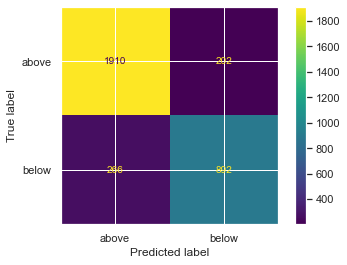

In [33]:
# Threshold 0,5
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_pipe.classes_)
disp.plot()
plt.show()

In [34]:
print(classification_report(y_val, y_pred, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.88      0.90      0.89      2112
       below       0.82      0.77      0.79      1158

    accuracy                           0.86      3270
   macro avg       0.85      0.84      0.84      3270
weighted avg       0.86      0.86      0.86      3270



### Change Threshold

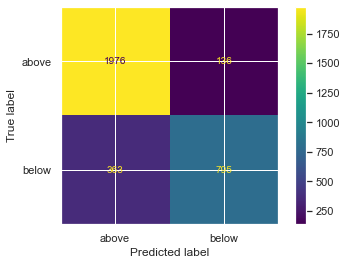

In [35]:
pred_proba = class_pipe.predict_proba(X_val)

y_pred_threshold = np.where(pred_proba[:,0] >= .4, 'above', 'below')

cm = confusion_matrix(y_val, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_pipe.classes_)
disp.plot()
plt.show()

In [36]:
print(classification_report(y_val, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.84      0.94      0.89      2112
       below       0.85      0.69      0.76      1158

    accuracy                           0.85      3270
   macro avg       0.85      0.81      0.82      3270
weighted avg       0.85      0.85      0.84      3270



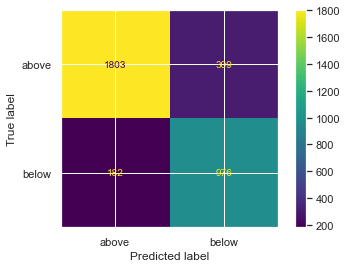

In [37]:
pred_proba = class_pipe.predict_proba(X_val)



y_pred_threshold2 = np.where(pred_proba[:,0] >= .6, 'above', 'below')

cm = confusion_matrix(y_val, y_pred_threshold2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_pipe.classes_)
disp.plot()
plt.show()

In [38]:
print(classification_report(y_val, y_pred_threshold2, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.91      0.85      0.88      2112
       below       0.76      0.84      0.80      1158

    accuracy                           0.85      3270
   macro avg       0.83      0.85      0.84      3270
weighted avg       0.86      0.85      0.85      3270



Mit der gleichen Begründung wie im ersten Modell wird hier das Modell mit dem besten F1-Score, also das Modell mit dem Threshold von 0,5 gewählt.

# Finale Evaluation mit Testdaten

## Anpassung Testdaten

### Anpassung datatypes & Bereinigung

Die Anpassung der Datentypen und das Entfernen der nicht benötigten Spalten muss genauso durchgeführt werden wie bei den Trainingsdaten.

In [39]:
# droppen von NULL Values
test_dataset = test_dataset.dropna()

In [40]:
# Anpassung der datatypes
test_dataset['median_house_value'] = test_dataset['median_house_value'].astype("float64")
test_dataset['housing_median_age'] = test_dataset['housing_median_age'].astype("float64")
test_dataset['total_bedrooms'] = test_dataset['total_bedrooms'].astype("int64")
test_dataset['ocean_proximity'] = test_dataset['ocean_proximity'].astype("category")

In [41]:
#correct price_category values
test_dataset['updated_price_cat'] = np.where(test_dataset.median_house_value >= 150000, 'above', 'below')

In [42]:
test_dataset['updated_price_cat'] = test_dataset['updated_price_cat'].astype("category")

In [43]:
test_dataset = test_dataset.drop(columns=['price_category'])
test_dataset = test_dataset.drop(columns=['median_house_value'])

### Feature Engineering Testdaten

Für die Testdaten müssen die gleichen Anpassungen an den Features durchgeführt werden wie bei den Trainingsdaten.

In [44]:
# neue Varaiablen müssen auch in den Testdaten ergänzt werden
test_dataset=test_dataset.assign(people_per_household=lambda test_dataset: test_dataset.population/test_dataset.households)
test_dataset=test_dataset.assign(bedrooms_per_household=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.households)
test_dataset=test_dataset.assign(rooms_per_household=lambda test_dataset: test_dataset.total_rooms/test_dataset.households)
test_dataset=test_dataset.assign(bedrooms_per_room=lambda test_dataset: test_dataset.total_bedrooms/test_dataset.total_rooms)

In [45]:
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("ISLAND", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("NEAR BAY", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("NEAR OCEAN", "NEAR WATER", regex =True)
test_dataset.ocean_proximity = test_dataset.ocean_proximity.str.replace("<1H OCEAN", "NEAR WATER", regex =True)

In [46]:
# durch die gerade stattgefundene Transformation muss der datatype wieder korrigiert werden
test_dataset['ocean_proximity'] = test_dataset['ocean_proximity'].astype("category")

## Split Testdaten

In [47]:
X2 = test_dataset.drop(columns=['updated_price_cat','ocean_proximity'])
y2 = test_dataset.updated_price_cat

## Validierung Classification mit statsmodels

Hier wird das Classification Modell von statsmodels evaluiert. Zur Visualisierung wird die Confusion Matrix und der Classification Report verwendet.

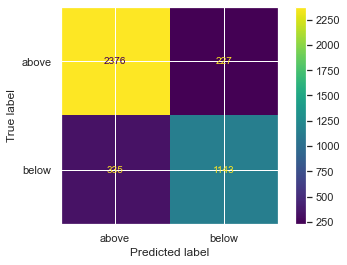

In [48]:
y_pred_test1 = model1.predict(test_dataset)

y_pred_test3 = np.where(y_pred_test1 >= .5, 'above', 'below')

cm = confusion_matrix(y2, y_pred_test3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_pipe.classes_)
disp.plot()
plt.show()

In [49]:
print(classification_report(y2, y_pred_test3, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.88      0.91      0.89      2603
       below       0.83      0.77      0.80      1478

    accuracy                           0.86      4081
   macro avg       0.86      0.84      0.85      4081
weighted avg       0.86      0.86      0.86      4081



In der Evaluation mit den Testdaten schneidet das Modell leicht schlechter ab als mit den Trainingsdaten, liefert aber immernoch ein zufriedenstellendes Ergebnis.  

Zum Vergleich die KPIs mit den Trainingsdaten:  
Accuracy:  0.8523  
Precision: 0.8667  
Recall:    0.9058  
F1 Score:  0.8858

## Validierung Classification mit scikit learn

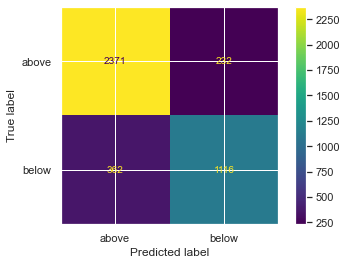

In [50]:
pred_proba = class_pipe.predict_proba(X2)

y_pred_test2 = np.where(pred_proba[:,0] >= .5, 'above', 'below')

cm = confusion_matrix(y2, y_pred_test2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_pipe.classes_)
disp.plot()
plt.show()

In [51]:
print(classification_report(y2, y_pred_test2, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.87      0.91      0.89      2603
       below       0.83      0.76      0.79      1478

    accuracy                           0.85      4081
   macro avg       0.85      0.83      0.84      4081
weighted avg       0.85      0.85      0.85      4081



Auch dieses Modell schneidet in der Evaluation mit den Testdaten leicht schlechter ab als mit den Trainingsdaten, liefert aber immernoch ein zufriedenstellendes Ergebnis.  

Zum Vergleich die KPIs mit den Trainingsdaten:  

In [52]:
# Classification Report mit Trainingsdaten Threshold 0,5
print(classification_report(y_val, y_pred, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.88      0.90      0.89      2112
       below       0.82      0.77      0.79      1158

    accuracy                           0.86      3270
   macro avg       0.85      0.84      0.84      3270
weighted avg       0.86      0.86      0.86      3270



>**Fazit**: Das Classification Modell von statsmodels schneidet in der Evaluation leicht besser ab als das von scikit learn. Ein F1-Score von 0.85 erfüllt unser zu Beginn gesetztes Ziel.